In [ ]:
# Install required packages
!pip install yt-dlp opencv-python-headless

In [ ]:
import cv2
import yt_dlp
import numpy as np
from google.colab.patches import cv2_imshow
import time

In [ ]:
def download_video(url, output_path='/downloaded_video.mp4'):
    """Download a video from YouTube or other supported platforms"""
    # Options for yt-dlp
    ydl_opts = {
        'format': 'best[height<=720]',  # Limit resolution to make processing faster
        'outtmpl': output_path  # Output file path
    }

    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        ydl.download([url])
    print(f"Video downloaded successfully: {output_path}")
    return output_path

# URL of the space shuttle launch video
video_url = 'https://www.youtube.com/watch?v=Vfn_u768UoQ'

# Download the video
print("Downloading space shuttle launch video. This may take a moment...")
video_path = download_video(video_url, '/downloaded_video.mp4')

[youtube] Extracting URL: https://www.youtube.com/watch?v=Vfn_u768UoQ
[youtube] Vfn_u768UoQ: Downloading webpage
[youtube] Vfn_u768UoQ: Downloading tv client config
[youtube] Vfn_u768UoQ: Downloading player c548b3da
[youtube] Vfn_u768UoQ: Downloading tv player API JSON
[youtube] Vfn_u768UoQ: Downloading ios player API JSON
[youtube] Vfn_u768UoQ: Downloading m3u8 information
[info] Vfn_u768UoQ: Downloading 1 format(s): 18
[download] Destination: /downloaded_video.mp4
[download] 100% of 1007.27KiB in 00:00:00 at 11.64MiB/s  
Video downloaded successfully: /downloaded_video.mp4


In [ ]:
def track_space_shuttle_launch(video_path, tracker_type="KCF"):
    """Track specific objects in the space shuttle launch video"""
    # Open the video
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    # Read the first frame
    ret, frame = cap.read()
    if not ret:
        print("Error: Couldn't read the first video frame.")
        return

    # Get frame dimensions
    frame_height, frame_width = frame.shape[:2]
    print(f"Video dimensions: {frame_width}x{frame_height}")

    # Display the first frame
    print("First frame of the space shuttle launch video:")
    cv2_imshow(frame)

    # Define objects to track in this specific space shuttle video
    # These coordinates target:
    # 1. The space shuttle itself
    # 2. The countdown clock/timer (if visible)
    # 3. The launch pad area

    # Set bounding boxes based on the frame dimensions
    # Note: These are approximate and may need adjustment based on the exact frame
    bboxes = [
        # Main shuttle/rocket area - center of the frame
        (int(frame_width * 0.4), int(frame_height * 0.3), int(frame_width * 0.2), int(frame_height * 0.4)),

        # Launch pad infrastructure
        (int(frame_width * 0.3), int(frame_height * 0.6), int(frame_width * 0.4), int(frame_height * 0.3)),

        # NASA logo/countdown timer area (if visible)
        (int(frame_width * 0.1), int(frame_height * 0.1), int(frame_width * 0.2), int(frame_height * 0.1))
    ]

    # Distinct colors for each tracked object
    colors = [
        (0, 0, 255),    # Red for shuttle/rocket
        (0, 255, 0),    # Green for launch pad
        (255, 0, 0)     # Blue for timer/logo
    ]

    object_labels = ["Shuttle/Rocket", "Launch Pad", "Timer/Logo"]

    # Create MultiTracker object
    multi_tracker = cv2.legacy.MultiTracker_create()

    # Initialize MultiTracker with first frame and bounding boxes
    for bbox in bboxes:
        if tracker_type == "CSRT":
            tracker = cv2.legacy.TrackerCSRT_create()
        elif tracker_type == "KCF":
            tracker = cv2.legacy.TrackerKCF_create()
        elif tracker_type == "MOSSE":
            tracker = cv2.legacy.TrackerMOSSE_create()
        else:
            tracker = cv2.legacy.TrackerKCF_create()  # Default

        multi_tracker.add(tracker, frame, bbox)

    print(f"Starting tracking with {tracker_type} tracker. Tracking {len(bboxes)} objects in the space shuttle launch.")

    # Show initial tracking boxes on first frame
    success, boxes = multi_tracker.update(frame)
    first_frame_with_boxes = frame.copy()

    if success:
        for i, box in enumerate(boxes):
            x, y, w, h = [int(v) for v in box]
            cv2.rectangle(first_frame_with_boxes, (x, y), (x + w, y + h), colors[i], 2)
            cv2.putText(first_frame_with_boxes, object_labels[i], (x, y - 5),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, colors[i], 2)

    print("Initial tracking setup:")
    cv2_imshow(first_frame_with_boxes)

    print("Processing video frames...")

    # For space shuttle launch, let's capture key moments
    # These are the frame numbers we want to show (adjust based on video length)
    key_frame_numbers = [
        1,      # Start
        300,    # Early countdown
        600,    # Mid countdown
        900,    # Late countdown
        1200,   # Final countdown
        1500,   # Ignition if it occurs
        1800,   # Liftoff if it occurs
        2100    # Ascent if it occurs
    ]

    frame_count = 0
    shown_frames = 0

    # Loop through video frames
    while cap.isOpened() and shown_frames < len(key_frame_numbers):
        # Read a frame
        ret, frame = cap.read()

        if not ret:
            print("End of video")
            break

        frame_count += 1

        # Only process specific key frames
        if frame_count not in key_frame_numbers:
            continue

        # Update tracking
        success, boxes = multi_tracker.update(frame)

        # Draw tracked objects
        if success:
            for i, box in enumerate(boxes):
                x, y, w, h = [int(v) for v in box]
                cv2.rectangle(frame, (x, y), (x + w, y + h), colors[i], 2)
                cv2.putText(frame, object_labels[i], (x, y - 5),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.7, colors[i], 2)

        # Display the frame with tracking boxes
        print(f"Frame {frame_count} (approx. {frame_count/30:.1f} seconds into video):")
        cv2_imshow(frame)
        shown_frames += 1

        # Add a short delay to make sure images are displayed properly
        time.sleep(0.5)

    # Release resources
    cap.release()
    print("Tracking complete.")
    print("Note: For more precise tracking of the rocket during launch, specialized detection algorithms would typically be used.")

Video dimensions: 640x360
First frame of the space shuttle launch video:


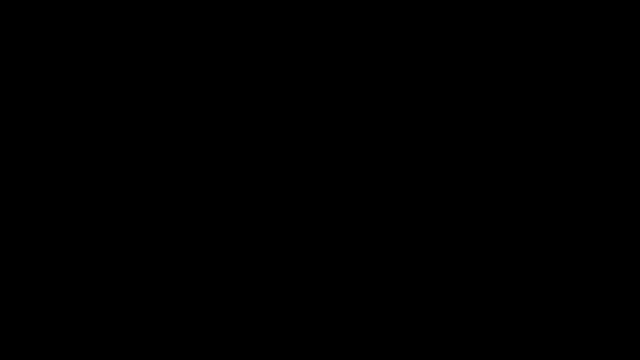

Starting tracking with CSRT tracker. Tracking 3 objects in the space shuttle launch.
Initial tracking setup:


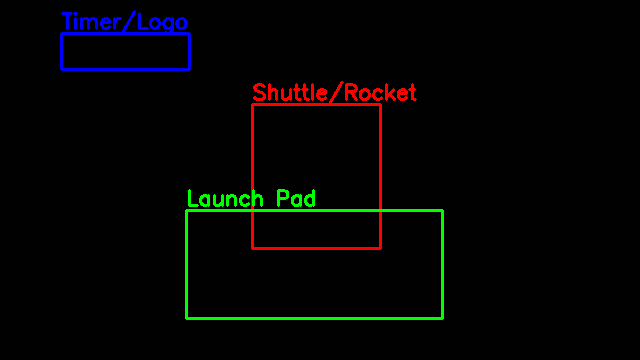

Processing video frames...
Frame 1 (approx. 0.0 seconds into video):


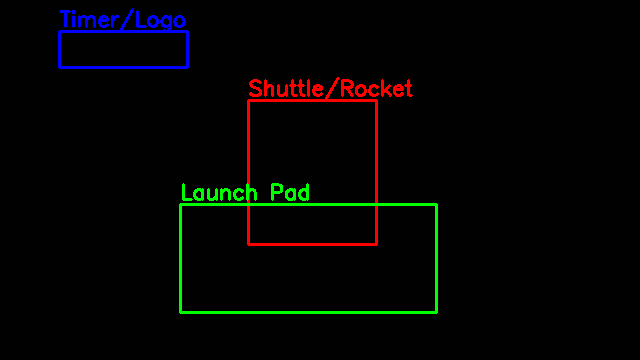

Frame 300 (approx. 10.0 seconds into video):


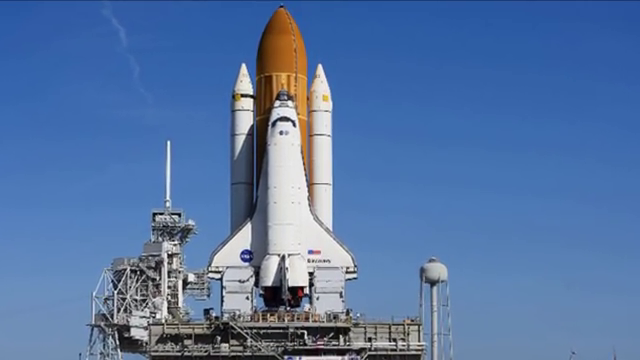

End of video
Tracking complete.
Note: For more precise tracking of the rocket during launch, specialized detection algorithms would typically be used.


In [ ]:
# Run the tracking function with the space shuttle launch video
track_space_shuttle_launch(video_path, "CSRT")  # CSRT tracker is more accurate for this type of video